<a href="https://colab.research.google.com/github/hongsukyi/tensorflow-for-beginners/blob/master/Samsung.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM,Dense
import matplotlib.pyplot as plt

## Prediction of Closing Price of Stock LSTM
The goal is to predict the Closing Price behavior of a single company by predicting `n` coming days (`foward_days`), using as input the `m` past days (`look_back`).

### (Prevendo o preço de uma ação no mercado de ações)

O objetivo é prever o que acontecerá com o valor de fechamento de uma ação em `n` dias (`foward_days`), tendo como base os `m` dias anteriores (`look_back`).

In [2]:
look_back = 40
foward_days = 10

First, just open the CSV using Pandas, set the `Date` as index and keep only the Closing Price column.

Primeiro, vamos abrir o CSV com o Pandas, colocar as datas como index e manter apenas a coluna que queremos prever, que é o preço de fechamento.

In [4]:
from google.colab import files
uploaded = files.upload()

Saving samsung.csv to samsung.csv


In [5]:
#open the csv
df = pd.read_csv('samsung.csv')
#set date as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
#keep only the 'Close' column
df = df['Close']

df.head()

Date
2010-01-08    16420.0
2010-01-11    15940.0
2010-01-12    16180.0
2010-01-13    15940.0
2010-01-14    16540.0
Name: Close, dtype: float64

In [6]:
len(df)

2220

### Data visualization  ( Vizualizando os dados )

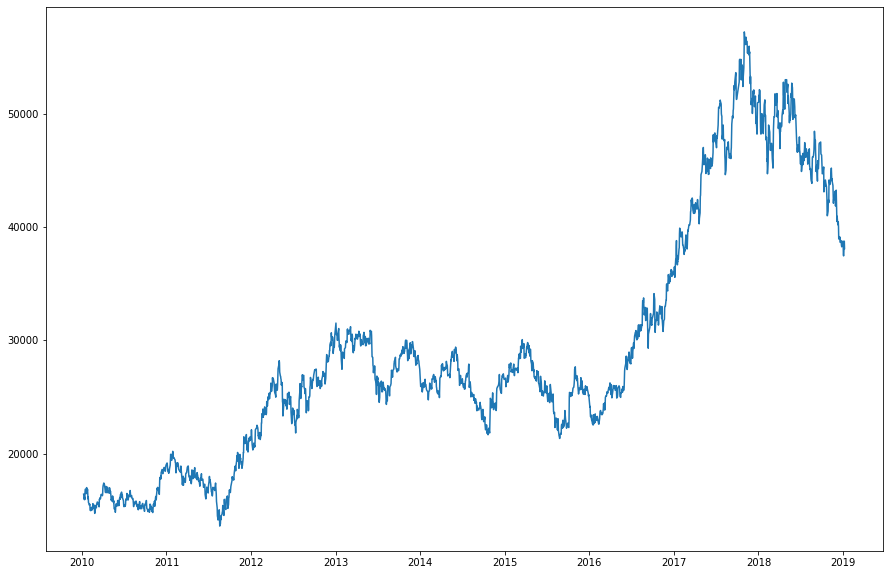

In [7]:
plt.figure(figsize = (15,10))
plt.plot(df)
plt.show()

### Data normalization  ( Normalizando os dados )

In [8]:
array = df.values.reshape(df.shape[0],1)
array[:5]

array([[16420.],
       [15940.],
       [16180.],
       [15940.],
       [16540.]])

In [9]:
from sklearn.preprocessing import MinMaxScaler
scl = MinMaxScaler()
array = scl.fit_transform(array)
array[:5]

array([[0.06464924],
       [0.05364512],
       [0.05914718],
       [0.05364512],
       [0.06740028]])

### Split the data in Data to Train/Validate the LSTM and Data to Test the model

The Test set will be the last `k` (`num_periods`) periods we want test the model. In each period, the model will predict the next `n` coming days. The remaning data will be used for Train/Validation.

### ( Dividir os dados em Treino/Validação para o modelo LSTM e os dados de Teste)
Vamos separar para os últimos `k` períodos (`num_periods`) para testar o modelo. A cada período, o modelo irá prever os próximos `n` dias. O resto será utilizado para o treinamento (Treino e Validação).

In [10]:
num_periods = 10

division = len(array) - num_periods*foward_days

array_test = array[division-look_back:]
array_train = array[:division]

In [11]:
#Get the data and splits in input X and output Y, by spliting in `n` past days as input X 
#and `m` coming days as Y.
def processData(data, look_back, foward_days,jump=1):
    X,Y = [],[]
    for i in range(0,len(data) -look_back -foward_days +1, jump):
        X.append(data[i:(i+look_back)])
        Y.append(data[(i+look_back):(i+look_back+foward_days)])
    return np.array(X),np.array(Y)

In [12]:
X_test,y_test = processData(array_test,look_back,foward_days,foward_days)
y_test = np.array([list(a.ravel()) for a in y_test])

X,y = processData(array_train,look_back,foward_days)
y = np.array([list(a.ravel()) for a in y])

from sklearn.model_selection import train_test_split
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.20, random_state=42)

In [13]:
print(X_train.shape)
print(X_validate.shape)
print(X_test.shape)
print(y_train.shape)
print(y_validate.shape)
print(y_test.shape)

(1576, 40, 1)
(395, 40, 1)
(20, 40, 1)
(1576, 10)
(395, 10)
(20, 10)


## Training the LSTM (Treinando a LSTM)

In [17]:
NUM_NEURONS_FirstLayer = 64
NUM_NEURONS_SecondLayer = 32
EPOCHS = 10

#Build the model
model = Sequential()
model.add(LSTM(NUM_NEURONS_FirstLayer,input_shape=(look_back,1), return_sequences=True))
model.add(LSTM(NUM_NEURONS_SecondLayer,input_shape=(NUM_NEURONS_FirstLayer,1)))
model.add(Dense(foward_days))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train,y_train,epochs=EPOCHS,validation_data=(X_validate,y_validate),shuffle=True,batch_size=2, verbose=1)

Epoch 1/20
788/788 [==============================] - 26s 34ms/step - loss: 0.0031 - val_loss: 0.0010
Epoch 2/20
788/788 [==============================] - 26s 32ms/step - loss: 0.0012 - val_loss: 8.4067e-04
Epoch 3/20
788/788 [==============================] - 26s 33ms/step - loss: 0.0010 - val_loss: 7.4042e-04
Epoch 4/20
788/788 [==============================] - 27s 35ms/step - loss: 0.0010 - val_loss: 8.6947e-04
Epoch 5/20
788/788 [==============================] - 26s 33ms/step - loss: 9.2970e-04 - val_loss: 6.8415e-04
Epoch 6/20
788/788 [==============================] - 26s 33ms/step - loss: 8.5741e-04 - val_loss: 0.0014
Epoch 7/20
788/788 [==============================] - 26s 33ms/step - loss: 8.9643e-04 - val_loss: 6.8644e-04
Epoch 8/20
788/788 [==============================] - 26s 33ms/step - loss: 8.0662e-04 - val_loss: 7.9589e-04
Epoch 9/20
788/788 [==============================] - 26s 33ms/step - loss: 7.4906e-04 - val_loss: 6.7933e-04
Epoch 10/20
788/788 [=============

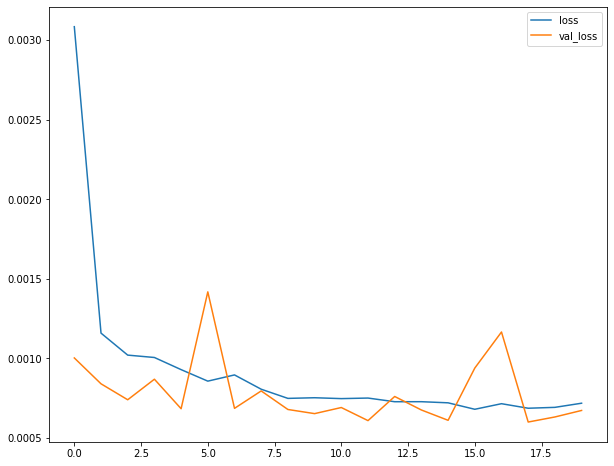

In [18]:
plt.figure(figsize = (10,8))

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='best')
plt.show()

### Predicting the Test Set to see the results  ( Vamos prever os dados de Teste para o resultado )

In [20]:
Xt = model.predict(X_test)

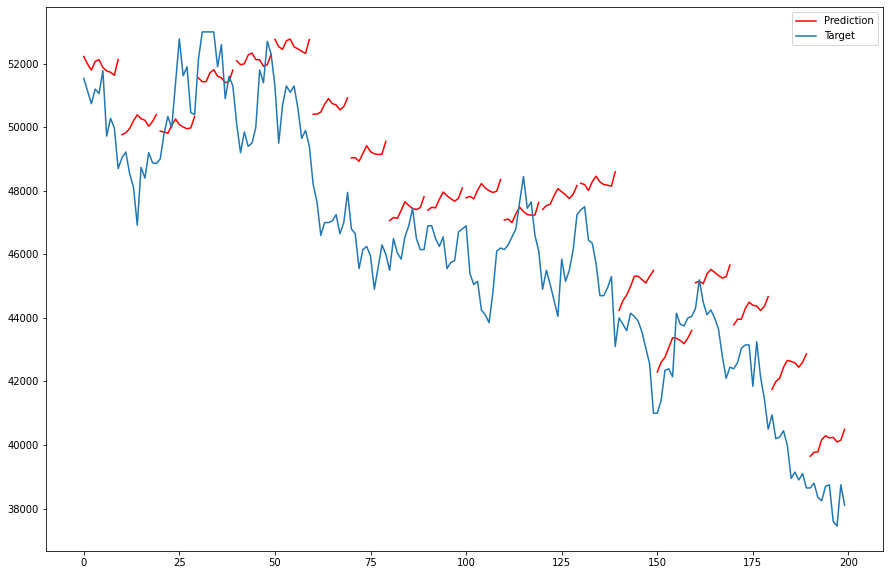

In [21]:
plt.figure(figsize = (15,10))

for i in range(0,len(Xt)):
    plt.plot([x + i*foward_days for x in range(len(Xt[i]))], scl.inverse_transform(Xt[i].reshape(-1,1)), color='r')
    
plt.plot(0, scl.inverse_transform(Xt[i].reshape(-1,1))[0], color='r', label='Prediction') #only to place the label
    
plt.plot(scl.inverse_transform(y_test.reshape(-1,1)), label='Target')
plt.legend(loc='best')
plt.show()

### Predicting all the data to see how the model reacts to Train and Test set
#### (Prever todos os dados para ver como o modelo reage aos dados de Treino e Teste)

In [22]:
#sepraro em Treino e Teste

division = len(array) - num_periods*foward_days

leftover = division%foward_days+1

array_test = array[division-look_back:]
array_train = array[leftover:division]

In [23]:
Xtrain,ytrain = processData(array_train,look_back,foward_days,foward_days)
Xtest,ytest = processData(array_test,look_back,foward_days,foward_days)

In [24]:
Xtrain = model.predict(Xtrain)
Xtrain = Xtrain.ravel()

Xtest = model.predict(Xtest)
Xtest = Xtest.ravel()

In [25]:
#y = ytrain.ravel() + ytest.ravel()
y = np.concatenate((ytrain, ytest), axis=0)

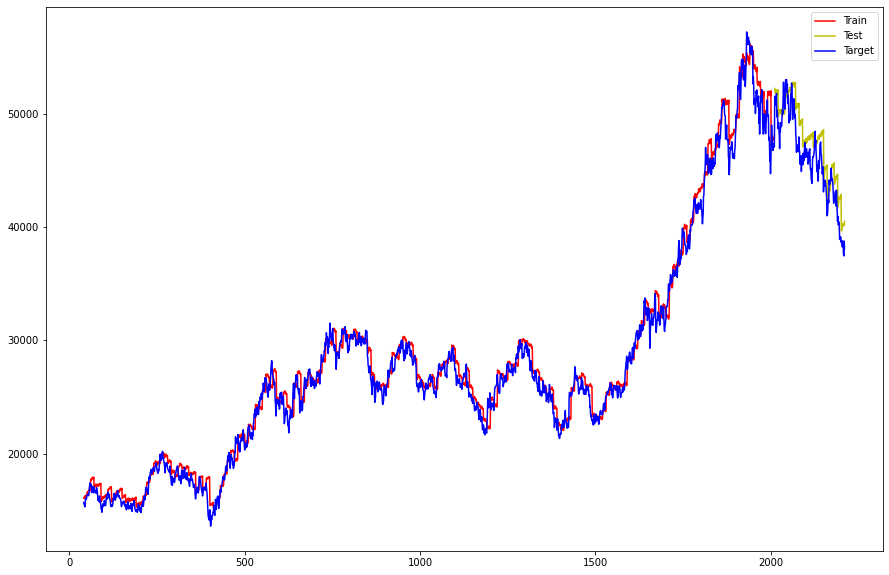

In [26]:
plt.figure(figsize = (15,10))

# Data in Train/Validation
plt.plot([x for x in range(look_back+leftover, len(Xtrain)+look_back+leftover)], scl.inverse_transform(Xtrain.reshape(-1,1)), color='r', label='Train')
# Data in Test
plt.plot([x for x in range(look_back +leftover+ len(Xtrain), len(Xtrain)+len(Xtest)+look_back+leftover)], scl.inverse_transform(Xtest.reshape(-1,1)), color='y', label='Test')

#Data used
plt.plot([x for x in range(look_back+leftover, look_back+leftover+len(Xtrain)+len(Xtest))], scl.inverse_transform(y.reshape(-1,1)), color='b', label='Target')

#Initial data. It should overlap the data uses
#plt.plot(scl.inverse_transform(array), color='b', label='Esperado')

plt.legend(loc='best')
plt.show()